# Identify generic genes and pathways

This notebooke performs the following steps to identify generic genes
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.

3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Evaluation:**
We want to compare our ranking using ponyo, compared to the ranking found from Crow et. al.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import calc, process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_test.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']
col_to_rank_genes = params['rank_genes_by']
compare_genes = params['compare_genes']

gene_summary_file = os.path.join(
    base_dir, 
    dataset_name, 
    "generic_gene_summary.tsv")

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

In [4]:
# Create results directories
output_dirs = [
    os.path.join(local_dir, "pseudo_experiment"),
    os.path.join(local_dir, "DE_stats"),
]

# Check if the following directories exist
# and if not to create them
for each_dir in output_dirs:

    # Check if analysis output directory exist otherwise create
    if not os.path.exists(each_dir):
        print("creating new directory: {}".format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

### Simulate experiments using selected template experiment

In [5]:
# Simulate multiple experiments
for i in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Check reproducibility of simulated experiments -- Found 318 columns with differences ~0.1
#template_path = "data/test_simulated_data_SRP012656_0.txt"
#template_df = pd.read_csv(template_path, sep="\t", header=0, index_col=0)
#output_path = os.path.join(local_dir, "pseudo_experiment", "selected_simulated_data_SRP012656_0.txt")
#output_df = pd.read_csv(output_path, sep="\t", header=0, index_col=0)
#assert np.all(np.isclose(output_df.values, template_df.values)), (
#    output_df.iloc[
#        np.where(~np.all(np.isclose(output_df.values, template_df.values), axis=1))[0],
#        np.where(~np.all(np.isclose(output_df.values, template_df.values), axis=0))[0],
#    ],
#)

In [7]:
# Check reproducibility of simulated experiments
# Commenting this out for now 
#template_path = "data/test_simulated_data_SRP012656_1.txt"
#output_path = os.path.join(local_dir, "pseudo_experiment", "selected_simulated_data_SRP012656_1.txt")
#assert np.all(np.isclose(
#    pd.read_csv(output_path, sep="\t", header=0, index_col=0).values,
#    pd.read_csv(template_path, sep="\t", header=0, index_col=0).values
#    ))

Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/0_explore_input_data.ipynb)

In [8]:
# Remove subset of samples
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

process.subset_samples(smRNA_samples,
                      num_runs,
                      local_dir,
                      project_id)

In [9]:
# Round simulated read counts to int in order to run DESeq
process.recast_int(num_runs, local_dir, project_id)

### Differential expression analysis

In [10]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [11]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
BiocManager::install("limma")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package(s) 'DESeq2'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://bioconductor.org/packages/3.10/bioc/src/contrib/DESeq2_1.26.0.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRunt

In [12]:
%%R
# Load the DESeq2 library
suppressPackageStartupMessages(library("DESeq2"))

In [13]:
# Check ordering of sample ids is consistent between gene expression data and metadata
process.compare_and_reorder_samples(template_data_file, metadata_file)

sample ids are ordered correctly


In [14]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

get_DE_stats_DESeq(metadata_file,
                   project_id, 
                   template_data_file,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE


In [15]:
# Check ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt")
        
    process.compare_and_reorder_samples(simulated_data_file, metadata_file)

sample ids are ordered correctly
sample ids are ordered correctly


In [16]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs

source('../generic_expression_patterns_modules/DE_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    run_output <- get_DE_stats_DESeq(metadata_file,
                                     project_id, 
                                     simulated_data_file,
                                     "simulated",
                                     local_dir,
                                     i)
}

[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE


In [31]:
assert os.path.exists(os.path.join(local_dir, "DE_stats", "DE_stats_simulated_data_SRP012656_0.txt"))

### Rank genes

In [17]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(os.path.abspath(local_dir), num_runs, project_id, 'DE')

print(simulated_DE_stats_all.shape)

(35574, 7)


In [18]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [19]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(col_to_rank_genes,
                                                  simulated_DE_stats_all,
                                                  'DE')

In [20]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes_or_pathways(col_to_rank_genes,
                                                template_DE_stats,
                                                True)

In [21]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes_or_pathways(col_to_rank_genes,
                                                         simulated_DE_summary_stats,
                                                         False)

### Gene summary table

In [22]:
summary_gene_ranks = process.generate_summary_table(template_DE_stats,
                                                   simulated_DE_summary_stats,
                                                   col_to_rank_genes,
                                                   local_dir)

summary_gene_ranks.head()

(17787, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.949499e-13,17600.0,10.694081,9.066845e-02,13305.0,1.119155,0.315878,2,30.312072
PRAME,PRAME,2.958919e-15,17599.0,8.664888,2.513922e-08,12863.0,1.035778,0.050535,2,150.967549
SLCO1B3,SLCO1B3,5.297924e-04,17598.0,8.325387,4.438485e-26,15950.0,1.892711,0.041667,2,154.384779
KCNC2,KCNC2,1.985163e-10,17597.0,8.230487,2.032108e-01,7594.0,0.428248,0.148522,2,52.532707
HOTAIR,HOTAIR,3.122050e-10,17596.0,8.228219,3.635389e-12,14329.0,1.333546,0.099318,2,69.419885


In [23]:
summary_gene_ranks.to_csv(
    gene_summary_file, sep='\t')

In [24]:
# Check reproducibility of summary ranks
#template_path = "data/test_generic_gene_summary.tsv"
#template_df = pd.read_csv(template_path, sep="\t", header=0, index_col=0)
#output_df = pd.read_csv(gene_summary_file, sep="\t", header=0, index_col=0)
#assert (template_df["Gene ID"].values == output_df["Gene ID"].values).all(),template_df.loc[template_df["Gene ID"].values != output_df["Gene ID"].values,"Gene ID"]

#assert np.all(np.isclose(
#    template_df[["Rank (Real)", "Rank (simulated)"]].values,
#    output_df[["Rank (Real)", "Rank (simulated)"]].values),
#    output_df[["Rank (Real)", "Rank (simulated)"]].iloc[
#        np.where(~np.all(np.isclose(output_df[["Rank (Real)", "Rank (simulated)"]].values, template_df[["Rank (Real)", "Rank (simulated)"]].values), axis=1))[0],
#        np.where(~np.all(np.isclose(output_df[["Rank (Real)", "Rank (simulated)"]].values, template_df[["Rank (Real)", "Rank (simulated)"]].values), axis=0))[0],
#    ]

#)

### Compare gene ranking
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

0.249283569845042 2.2038254570820847e-222 0.23728041277854325 0.2693927464592069


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


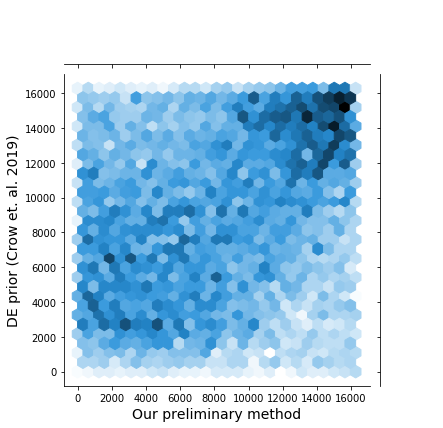

In [26]:
if compare_genes:
    # Get generic genes identified by Crow et. al.
    DE_prior_file = params['reference_gene_file']
    ref_gene_col = params['reference_gene_name_col']
    ref_rank_col = params['reference_rank_col']
    
    # Merge our ranking and reference ranking
    shared_gene_rank_df = process.merge_ranks_to_compare(
        summary_gene_ranks,
        DE_prior_file,
        ref_gene_col,
        ref_rank_col)
    
    if max(shared_gene_rank_df["Rank (simulated)"]) != max(shared_gene_rank_df[ref_rank_col]):
        shared_gene_rank_scaled_df = process.scale_reference_ranking(shared_gene_rank_df, ref_rank_col).dropna()
    else:
        shared_gene_rank_scaled_df = shared_gene_rank_df.dropna()
        
    # Get correlation
    r, p, ci_low, ci_high = calc.spearman_ci(0.95,
                                             shared_gene_rank_scaled_df,
                                             100,
                                             'DE')
    print(r, p, ci_low, ci_high)
    assert(np.all(np.isclose([r,p],
                             [0.249283569845042, 2.2038254570820847e-222]
                            )
                 )
          )

    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "gene_ranking_"+col_to_rank_genes+".svg")

    fig = sns.jointplot(data=shared_gene_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex',
                        marginal_kws={'color':'white'})
    fig.set_axis_labels("Our preliminary method", "DE prior (Crow et. al. 2019)", fontsize=14)

    fig.savefig(fig_file,
                format='svg',
                bbox_inches="tight",
                transparent=True,
                pad_inches=0,
                dpi=300,)

**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate the some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.